# Detailed Maintenance Records Analysis

This notebook performs a comprehensive analysis of ice machine maintenance records to extract insights about:
1. Task categories and their distribution
2. Common maintenance issues
3. Frequently replaced parts
4. Maintenance patterns and trends

In [18]:
import nltk
import os
from nltk.data import find
from importlib import reload

# Function to quietly download NLTK data if not present
def download_nltk_data_quiet():
    try:
        find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt', quiet=True)
    
    try:
        find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords', quiet=True)

# Download required NLTK data quietly
download_nltk_data_quiet()

In [19]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')


In [20]:
# Define the path to ice makers' data file
csv_file_path = 'data/ice_makers.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

In [21]:
# Combine the records from the specified columns into 'combined_column' without changing the original columns
df = df.copy()  # Create a copy to avoid SettingWithCopyWarning
df.loc[:, 'combined_column'] = df.apply(
    lambda row: ' '.join([str(row['wrkordr_wrk_prfrmd']) if pd.notna(row['wrkordr_wrk_prfrmd']) else '',
                          str(row['wrkordreqpmnt_wrk_prfrmd']) if pd.notna(row['wrkordreqpmnt_wrk_prfrmd']) else '',
                          str(row['wrkordrinvntry_dscrptn']) if pd.notna(row['wrkordrinvntry_dscrptn']) else '']),
    axis=1
)

In [22]:
# Replace non-alphanumeric characters with a space using .loc
df.loc[:, 'combined_column'] = df['combined_column'].str.replace(r'[^a-zA-Z0-9\s]', ' ', regex=True)

# Replace carriage return characters with a space using .loc
df.loc[:, 'combined_column'] = df['combined_column'].str.replace(r'\r', ' ', regex=True)

In [23]:
# Select a random sample of 100 records from the DataFrame
# df_filtered = df.sample(n=10000, random_state=42)

In [33]:
def categorize_task(text):
    """Categorize maintenance task based on keywords."""
    text = text.lower()
    
    # Define category keywords
    categories = {
        'Inspection': ['inspect', 'check', 'monitor', 'examine', 'verify', 'test', 'assess'],
        'Maintenance': ['replace', 'repair', 'install', 'adjust', 'calibrate', 'lubricate', 'tighten'],
        'Cleaning': ['clean', 'wash', 'brush', 'descale', 'sanitize', 'flush'],
        'Emergency': ['emergency', 'failure', 'breakdown', 'not working', 'error', 'alarm']
    }
    
    for category, keywords in categories.items():
        if any(keyword in text for keyword in keywords):
            return category
    return 'Other'

def extract_parts(text):
    """Extract mentioned parts and components."""
    text = text.lower()
    parts_dict = {
        'Mechanical': ['motor', 'belt', 'fan', 'filter', 'pump', 'bearing', 'wheel'],
        'Electrical': ['relay', 'contactor', 'board', 'thermostat', 'sensor', 'switch'],
        'Refrigeration': ['condenser', 'evaporator', 'refrigerant', 'r404', 'coil'],
        'Water System': ['valve', 'regulator', 'water filter', 'tube']
    }
    
    found_parts = defaultdict(list)
    for category, parts in parts_dict.items():
        for part in parts:
            if part in text:
                # Aggregate refrigerant mentions
                if part in ['refrigerant', 'r404']:
                    found_parts[category].append('refrigerant')
                else:
                    found_parts[category].append(part)
    return found_parts

def analyze_maintenance_records(df):
    """Perform comprehensive analysis of maintenance records."""
    results = {
        'task_categories': Counter(),
        'parts_mentioned': defaultdict(Counter),
        'common_phrases': Counter(),
        'emergency_incidents': []
    }
    
    # Process each record
    for text in df['combined_column'].dropna():
        # Categorize task
        category = categorize_task(text)
        results['task_categories'][category] += 1
        
        # Extract parts
        parts = extract_parts(text)
        for part_category, part_list in parts.items():
            results['parts_mentioned'][part_category].update(part_list)
        
        # Extract common phrases (2-3 word combinations)
        words = word_tokenize(text.lower())
        for i in range(len(words)-1):
            phrase = ' '.join(words[i:i+2])
            if all(len(word) > 2 for word in phrase.split()):
                results['common_phrases'][phrase] += 1
        
        # Track emergency incidents
        if category == 'Emergency':
            results['emergency_incidents'].append(text)
    
    return results

In [37]:
def plot_task_distribution(results):
    """Plot distribution of maintenance tasks by category."""
    categories = results['task_categories']
    total = sum(categories.values())
    
    # Create pie chart
    plt.figure(figsize=(10, 6))
    plt.pie([v/total*100 for v in categories.values()],
            labels=[f"{k}\n({v/total*100:.1f}%)" for k, v in categories.items()],
            autopct='%1.1f%%')
    plt.title('Distribution of Maintenance Tasks by Category')
    plt.show()

def plot_parts_frequency(results):
    """Plot frequency of parts mentioned by category."""
    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size': 16})  # Increased base font size

    data = []
    labels = []
    categories = []
    
    for category, parts in results['parts_mentioned'].items():
        for part, count in parts.most_common(5):  # Top 5 parts per category
            data.append(count)
            labels.append(part)
            categories.append(category)
    
    df_parts = pd.DataFrame({
        'Part': labels,
        'Count': data,
        'Category': categories
    })
    
    ax = sns.barplot(data=df_parts, x='Count', y='Part', hue='Category')
    plt.title('Most Frequently Mentioned Parts by Category', pad=10, fontsize=20)
    
    # Increase font sizes for labels and legend
    ax.tick_params(labelsize=18)  # Tick label size
    plt.xlabel('Count', fontsize=18)
    plt.ylabel('Part', fontsize=18)
    
    # Correct way to set legend properties
    legend = ax.legend(fontsize=16)
    legend.set_title('Category')
    legend.get_title().set_fontsize(18)  # Set legend title font size
    
    plt.tight_layout()
    plt.show()
    plt.savefig('temp_parts_plot.png', format='png', bbox_inches='tight', dpi=500)
    plt.close()
    plt.tight_layout()
    plt.show()
    plt.savefig('temp_parts_plot.png', format='png', bbox_inches='tight', dpi=500)
    plt.close()

def print_analysis_summary(results):

    # Task Categories
    total_tasks = sum(results['task_categories'].values())
    print("\nTask Categories Distribution:")
    for category, count in results['task_categories'].most_common():
        print(f"{category}: {count} ({count/total_tasks*100:.1f}%)")
    
    # Parts Analysis
    print("\nMost Common Parts by Category:")
    for category, parts in results['parts_mentioned'].items():
        print(f"\n{category}:")
        for part, count in parts.most_common(5):
            print(f"  - {part}: {count} mentions")
    
    # Common Phrases
    print("\nMost Common Maintenance Actions:")
    for phrase, count in results['common_phrases'].most_common(10):
        print(f"  - {phrase}: {count} occurrences")
    
    # Emergency Incidents
    print(f"\nEmergency Incidents: {len(results['emergency_incidents'])}")
    if results['emergency_incidents']:
        print("Sample emergency cases:")
        for incident in results['emergency_incidents'][:3]:
            print(f"  - {incident[:100]}...")

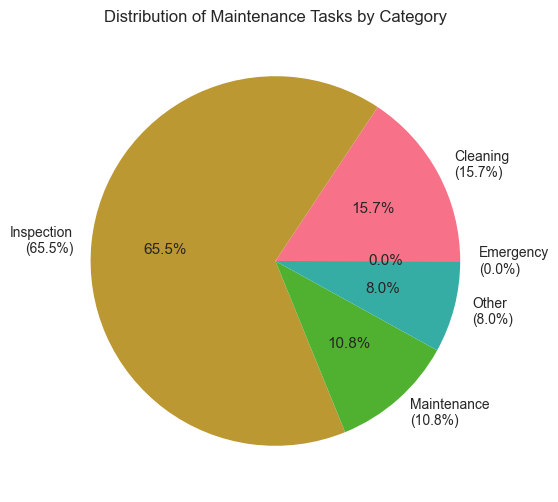

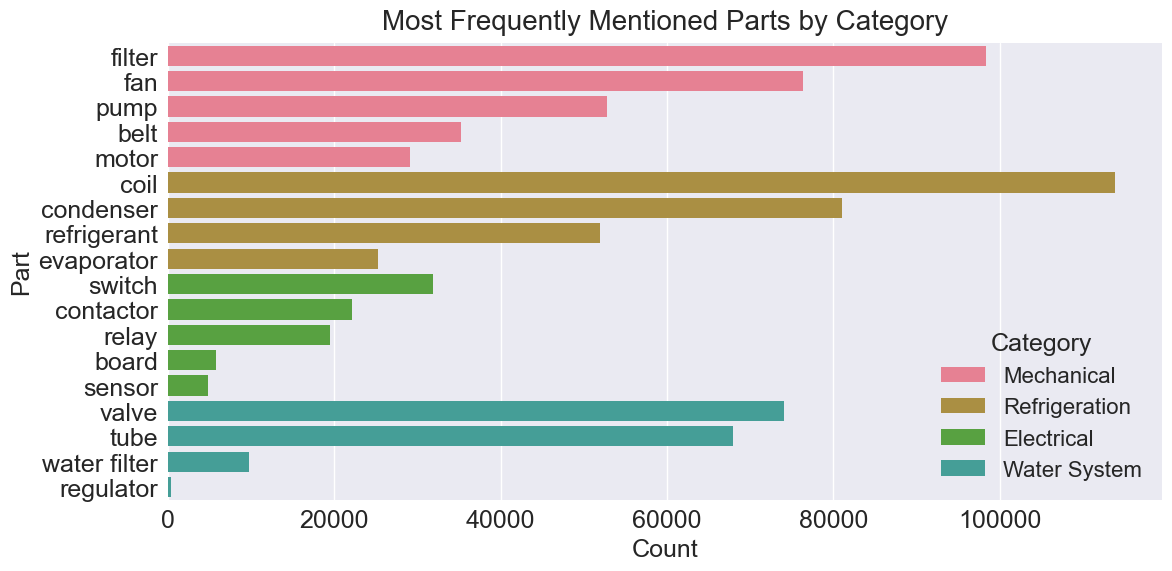

<Figure size 800x550 with 0 Axes>


Task Categories Distribution:
Inspection: 194223 (65.5%)
Cleaning: 46449 (15.7%)
Maintenance: 32058 (10.8%)
Other: 23772 (8.0%)
Emergency: 45 (0.0%)

Most Common Parts by Category:

Mechanical:
  - filter: 98337 mentions
  - fan: 76324 mentions
  - pump: 52819 mentions
  - belt: 35266 mentions
  - motor: 29058 mentions

Refrigeration:
  - coil: 113815 mentions
  - condenser: 81081 mentions
  - refrigerant: 51944 mentions
  - evaporator: 25254 mentions

Electrical:
  - switch: 31921 mentions
  - contactor: 22131 mentions
  - relay: 19498 mentions
  - board: 5816 mentions
  - sensor: 4888 mentions

Water System:
  - valve: 74108 mentions
  - tube: 67925 mentions
  - water filter: 9734 mentions
  - regulator: 430 mentions

Most Common Maintenance Actions:
  - ice machine: 319762 occurrences
  - the water: 174148 occurrences
  - the system: 118611 occurrences
  - contract none: 116409 occurrences
  - water supply: 111757 occurrences
  - turned the: 108911 occurrences
  - any ice: 108534 o

In [38]:
# Perform analysis
analysis_results = analyze_maintenance_records(df)

# Generate visualizations
plot_task_distribution(analysis_results)
plot_parts_frequency(analysis_results)

# Print detailed summary
print_analysis_summary(analysis_results)

In [54]:
# First define the capture_print_output function
from io import StringIO
import sys

def capture_print_output(func, *args, **kwargs):
    """Capture the print output of a function."""
    old_stdout = sys.stdout
    output_capture = StringIO()
    sys.stdout = output_capture
    func(*args, **kwargs)
    output_text = output_capture.getvalue()
    sys.stdout = old_stdout
    return output_text

# Now the rest of the code
# First generate the analysis results
analysis_results = analyze_maintenance_records(df)

# Capture the analysis text
analysis_text = capture_print_output(print_analysis_summary, analysis_results)

# Generate plots
def create_plots(results):
    # Plot 1: Task Distribution
    plt.figure(figsize=(6, 4))
    plt.rcParams.update({'font.size': 9})
    
    categories = results['task_categories']
    total = sum(categories.values())
    plt.pie([v/total*100 for v in categories.values()],
            labels=[f"{k}\n({v/total*100:.1f}%)" for k, v in categories.items()],
            autopct='%1.1f%%')
    plt.title('Distribution of Maintenance Tasks by Category', pad=10, fontsize=11)
    plt.savefig('temp_maintenance_plot.png', format='png', bbox_inches='tight', dpi=300)
    plt.close()

    # Plot 2: Parts Frequency with larger fonts
    plt.figure(figsize=(8, 4))
    plt.rcParams.update({'font.size': 11})
    
    data = []
    labels = []
    categories = []
    for category, parts in results['parts_mentioned'].items():
        for part, count in parts.most_common(5):
            data.append(count)
            labels.append(part)
            categories.append(category)

    df_parts = pd.DataFrame({
        'Part': labels,
        'Count': data,
        'Category': categories
    })

    ax = sns.barplot(data=df_parts, x='Count', y='Part', hue='Category')
    plt.title('Most Frequently Mentioned Parts by Category', pad=10, fontsize=14)
    
    # Increase font sizes for labels and legend
    ax.tick_params(labelsize=11)
    plt.xlabel('Count', fontsize=11)
    plt.ylabel('Part', fontsize=11)
    
    # Set legend with title
    legend = plt.legend(title='Category', fontsize=11)
    plt.setp(legend.get_title(), fontsize=11)
    
    plt.tight_layout()
    plt.savefig('temp_parts_plot.png', format='png', bbox_inches='tight', dpi=300)
    plt.close()

# Create the plots
create_plots(analysis_results)

# Now create the PDF with everything
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch

# Create the PDF
output_file = "maintenance_analysis_report.pdf"
doc = SimpleDocTemplate(
    output_file,
    pagesize=letter,
    rightMargin=48,
    leftMargin=48,
    topMargin=36,
    bottomMargin=36
)

# Define styles
styles = getSampleStyleSheet()
title_style = ParagraphStyle(
    'CustomTitle',
    parent=styles['Heading1'],
    fontSize=14,
    spaceAfter=12,
    alignment=1
)
heading_style = ParagraphStyle(
    'CustomHeading',
    parent=styles['Heading2'],
    fontSize=12,
    spaceAfter=8,
    spaceBefore=12,
    alignment=1
)
body_style = ParagraphStyle(
    'CustomBody',
    parent=styles['BodyText'],
    fontSize=10,
    leading=12
)

# Build the PDF content
story = []

# Add title
story.append(Paragraph("Maintenance Analysis Summary Report", title_style))
story.append(Spacer(1, 10))

# Add plots vertically
if os.path.exists('temp_maintenance_plot.png') and os.path.exists('temp_parts_plot.png'):
    # First plot with title
    story.append(Paragraph("Task Distribution Analysis", heading_style))
    story.append(Spacer(1, 5))
    img1 = Image('temp_maintenance_plot.png', width=5.*inch, height=4*inch)
    story.append(img1)
    story.append(Spacer(1, 10))
    
    # Second plot with title
    story.append(Paragraph("Parts Frequency Analysis", heading_style))
    story.append(Spacer(1, 5))
    img2 = Image('temp_parts_plot.png', width=6.5*inch, height=3.25*inch)
    story.append(img2)
    story.append(Spacer(1, 20))

# Add analysis text
story.append(Paragraph("Detailed Analysis Results", heading_style))
sections = analysis_text.split('\n\n')
for section in sections:
    if section.strip():
        if ':' in section.split('\n')[0]:
            header, *content = section.split('\n')
            story.append(Paragraph(header, heading_style))
            for line in content:
                if line.strip():
                    story.append(Paragraph(line, body_style))
        else:
            story.append(Paragraph(section, body_style))
        story.append(Spacer(1, 8))

# Generate the PDF
doc.build(story)

# Clean up temporary files
for temp_file in ['temp_maintenance_plot.png', 'temp_parts_plot.png']:
    if os.path.exists(temp_file):
        os.remove(temp_file)

print(f"PDF report has been generated: {output_file}")

PDF report has been generated: maintenance_analysis_report.pdf
